This notebook is used to look at how the raw2feat xcms processing differs from the new implementation of processing.

To use: just change out the .csv files that are inputted in the 3rd box.

Note: its specific for the malaria dataset ... need to generalize to run on any. 

In [2]:
%matplotlib inline 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, sys

root = os.getcwd()

In [3]:
def drop_redundant(df):
    seen = [] 
    indexes = []
    for ind, row in df.iterrows():
        if (row['mass_to_charge'], row['charge'], row['retention_time']) not in seen:
            seen.append((row['mass_to_charge'], row['charge'], row['retention_time']))
            continue
        else:
            indexes.append(ind)        
    return df.drop(indexes)

def drop_redundant_xcms(df):
    seen = []
    indexes = []
    for ind, row in df.iterrows():
        if (row['mz']) not in seen:
            seen.append((row['mz']))
            continue
        else:
            indexes.append(ind)        
    return df.drop(indexes)

In [5]:
study = '/MTBLS315/'
study_category = 'Malaria'

# using raw2feat.py (input was mzML data)
r2f_dir = 'r2f_mzXML/'
path = root+study+r2f_dir
data_file = 'MTBLS315_mzXML.aligned_table.batch_batchone.positive.csv'
r2f_data = pd.read_csv(path+data_file, sep=',')

# Get the new xcms script data with xcms3
new_xcms = 'data/'
path = root+study+new_xcms
new_xcms_neg_uplc_data_align = 'IPO_aligned_new_mzXML_P.csv'
new_xcms_neg_uplc_data_align = 'IPO_aligned_fixed_minfrac_etc_mzXML_P.csv'
# new_xcms_neg_uplc_data_all = 'allpeaksfile_malaria_N_mzML.csv'
#MAIN FILE VARIABLE FOR NEW XCMS SCRIPT:
fixed_ipo_data = pd.read_csv(path+new_xcms_neg_uplc_data_align, sep=',')

In [7]:
# old r2f for just one sample
sample = 'X100_P.45.MCMA526_522.16524.mzXML'
r2f_sample = r2f_data[['mz','rt',sample[:-6]]]
r2f_sample = r2f_sample.round(4)
print('shape r2f data, predropping redundant: ', r2f_sample.shape)
dropped_r2f_sample = drop_redundant_xcms(r2f_sample)
print('shape r2f data, postdropping redundant: ', dropped_r2f_sample.shape)

#new xcms output for just one sample
mzml_sample = sample
sample_mz_rt = fixed_ipo_data[['mz','rt',mzml_sample]]
sample_mz_rt = sample_mz_rt.round(4)
# sample_mz_rt = sample_mz_rt.dropna().round(4)
# new_xcms_1014 = new_xcms_1014.sort_values(by=[mzml_sample])
print('shape new xcms data, predropping redundant: ', sample_mz_rt.shape)
dropped_sample_mz_rt = drop_redundant_xcms(sample_mz_rt)
print('shape new xcms data, postdropping redundant: ', dropped_sample_mz_rt.shape)

# Find the masses that are shared between the data sets. 
seen = []
shared = []
masses_new = sorted(dropped_sample_mz_rt['mz'].values)
masses_r2f = dropped_r2f_1014['mz'].values
for ele in masses_new:
    if ele in masses_r2f:
        shared.append(ele)
print('m/z values found in both dataset: ', len(shared))

shape r2f data, predropping redundant:  (16933, 3)
shape r2f data, postdropping redundant:  (16396, 3)
shape new xcms data, predropping redundant:  (9547, 3)
shape new xcms data, postdropping redundant:  (8799, 3)


NameError: name 'dropped_r2f_1014' is not defined

0 0 0 0


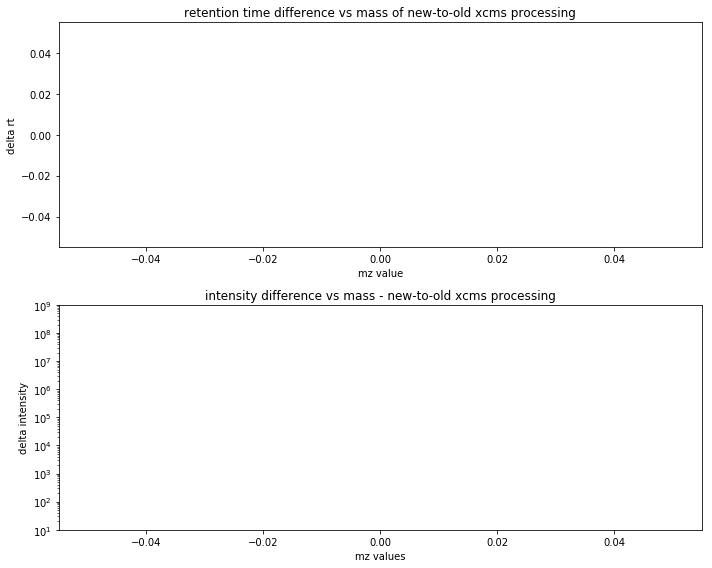

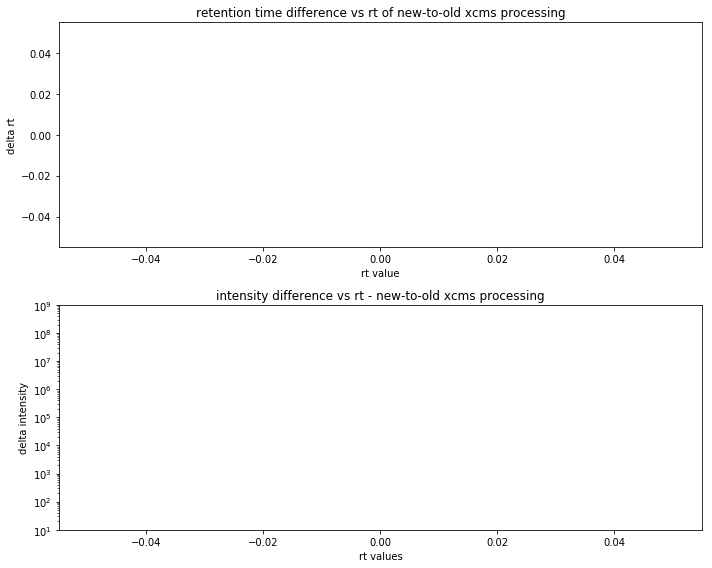

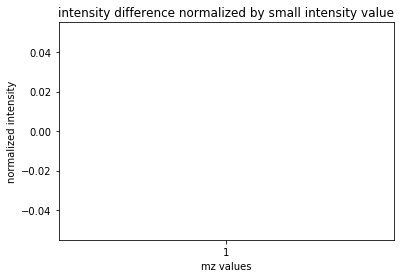

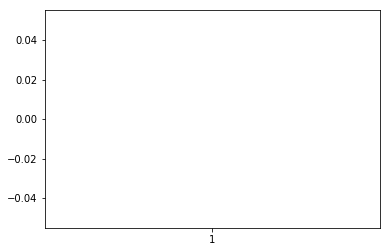

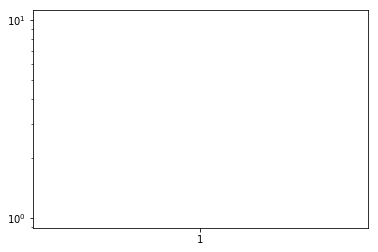

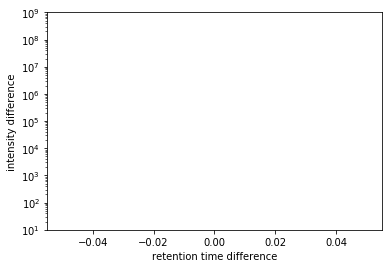

In [11]:
mz_real_dup = []
rt_real_dup = []
rt_diff = []
int_diff = []
diff_to_int_ratio = []
for ele in shared:
    data_r2f = r2f_1014[r2f_1014['mz'] == ele]
    data_new = new_xcms_1014[new_xcms_1014['mz'] == ele]
#     print('-----new------')
#     print(data_r2f)
#     print(data_new)
    
    mass_rt_real_dup = sorted([data_r2f.shape[0], data_new.shape[0]])[0]
    for i in range(mass_rt_real_dup):
        mz_real_dup.append(data_r2f.values[0,0])
        rt_real_dup.append(data_r2f.values[0,1])
    # get the rt differences
    if len(data_r2f['rt'].values) < len(data_new['rt'].values):
        for time_1 in data_r2f['rt'].values:
            data_r2f_times = []
            for time_2 in data_new['rt'].values:
                data_r2f_times.append(np.absolute(time_1-time_2))
            diff = sorted(data_r2f_times)[0]
            rt_diff.append(diff)
    else:
        for time_1 in data_new['rt'].values:
            data_times = []
            for time_2 in data_r2f['rt'].values:
                data_times.append(np.absolute(time_1-time_2))
            diff = sorted(data_times)[0]
            rt_diff.append(diff)
    # get the intensity differences:
    if len(data_r2f[sample].values) < len(data_new[mzml_sample].values):
        for int_1 in data_r2f[sample].values:
#             print('int 1', int_1)
            data_r2f_int = []
            for int_2 in data_new[mzml_sample].values:
#                 print('int 2', int_2)
                data_r2f_int.append(np.absolute(int_1-int_2))
            diff = sorted(data_r2f_int)[0] 
            diff_to_int_ratio.append(diff/int_1)
            int_diff.append(diff)
#             print('1',diff, data_r2f[sample].values, data_new[mzml_sample].values)
    else:
        for int_1 in data_new[mzml_sample].values:
            data_int = []
#             print('int 1', int_1)
            for int_2 in data_r2f[sample].values:
#                 print('int 2', int_2)
                data_int.append(np.absolute(int_1-int_2))
            diff = sorted(data_int)[0]
            diff_to_int_ratio.append(diff/int_1)
            int_diff.append(diff)
#             print('2', diff, data_r2f[sample].values, data_new[mzml_sample].values)

print(len(mz_real_dup), len(rt_diff), len(int_diff), len(rt_real_dup))
            
plt.figure(figsize=(10,8))
plt.subplot((211))
plt.scatter(mz_real_dup, rt_diff)
plt.title('retention time difference vs mass of new-to-old xcms processing')
plt.ylabel('delta rt')
plt.xlabel('mz value')

plt.subplot((212))
plt.scatter(mz_real_dup, int_diff)
plt.title('intensity difference vs mass - new-to-old xcms processing')
plt.ylabel('delta intensity')
plt.xlabel('mz values')
plt.yscale('log')
plt.ylim(1e1,1e9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,8))
plt.subplot((211))
plt.scatter(rt_real_dup, rt_diff)
plt.title('retention time difference vs rt of new-to-old xcms processing')
plt.ylabel('delta rt')
plt.xlabel('rt value')

plt.subplot((212))
plt.scatter(rt_real_dup, int_diff)
plt.title('intensity difference vs rt - new-to-old xcms processing')
plt.ylabel('delta intensity')
plt.xlabel('rt values')
plt.yscale('log')
plt.ylim(1e1,1e9)
plt.tight_layout()
plt.show()

plt.boxplot(diff_to_int_ratio)
plt.title('intensity difference normalized by small intensity value')
plt.ylabel('normalized intensity')
plt.xlabel('mz values')
plt.show()

plt.boxplot(rt_diff, ['retention time difference'])
plt.show()

plt.boxplot(int_diff, ['intensity difference'])
plt.yscale('log')
plt.show()

plt.scatter(rt_diff, int_diff)
plt.yscale('log')
plt.ylim(1e1,1e9)
plt.xlabel('retention time difference')
plt.ylabel('intensity difference')
plt.show()

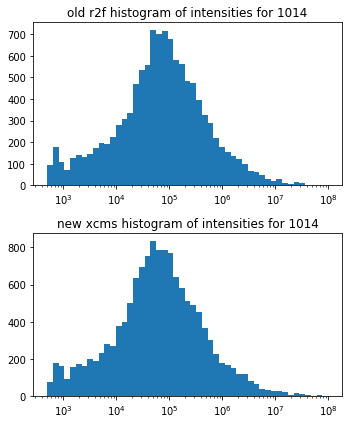

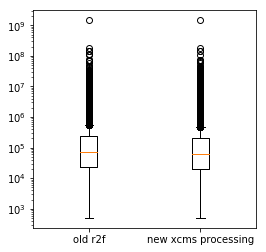

MannwhitneyuResult(statistic=72791494.0, pvalue=1.8879024046371605e-09)
Ks_2sampResult(statistic=0.04427244415635384, pvalue=6.293025565498678e-11)


In [83]:
plt.figure(figsize=(5,6))
plt.subplot(211)
plt.hist(r2f_1014[sample].values, bins=np.logspace(np.log10(5e2),np.log10(1e8),50))
plt.xscale('log')
plt.title('old r2f histogram of intensities for 1014')
plt.subplot(212)
plt.hist(new_xcms_1014[mzml_sample].values, bins=np.logspace(np.log10(5e2),np.log10(1e8),50))
plt.xscale('log')
plt.title('new xcms histogram of intensities for 1014')
plt.tight_layout()
plt.show()

plt.figure(figsize=(4,4))
plt.boxplot([r2f_1014[sample].values, new_xcms_1014[mzml_sample]], labels=['old r2f', 'new xcms processing'])
plt.yscale('log')
plt.show()

from scipy.stats import mannwhitneyu, ks_2samp
u_test = mannwhitneyu(r2f_1014[sample].values, new_xcms_1014[mzml_sample])
print(u_test)
ks_test = ks_2samp(r2f_1014[sample].values, new_xcms_1014[mzml_sample])
print(ks_test)